In [1]:
# read txt document of entry points
# also iterate over all tif files (adult 3D mask images) in the same path and perform analysis 
# all analysis except column analysis 

In [1]:
from scipy.ndimage.morphology import binary_fill_holes

from tqdm import tqdm
import os
import re
import tifffile as tif

import utils.analysis as analysis
import utils.datautils as datautils

import numpy as np
from skimage.measure import regionprops, marching_cubes, mesh_surface_area, perimeter
import pandas as pd
import math
from scipy.spatial import ConvexHull

import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib.patches as mpatches
# import seaborn as sns
%matplotlib inline

from timeit import default_timer as timer
from multiprocessing import cpu_count, Process, Pool

/tmp/ipykernel_1025674/391219825.py:1: DeprecationWarning: Please use `binary_fill_holes` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  from scipy.ndimage.morphology import binary_fill_holes


In [2]:
# def cal_lifetimes_angle(mask_img, plot=True):
#     lifetimes = analysis.cal_lifetimes(mask_img, save=False)
#     lifetimes = lifetimes[-1].astype(float)
#     lifetimes = 37+0.25*(lifetimes.max()-lifetimes)
    
#     t1 = lifetimes.copy()
#     t1[t1>40] = 0
#     t1 = t1.astype('uint8')
#     t1_center = regionprops(t1)[0].centroid
#     t2 = lifetimes.copy()
#     t2[t2<50] = 0
#     t2 = t2.astype('uint8')
#     t2_center = regionprops(t2)[0].centroid

#     x,y = (t2_center[-1]-t1_center[-1]) , (t2_center[-2]-t1_center[-2])

#     if plot:
#         y1,x1 = int(t1_center[-2]),int(t1_center[-1])
#         y2,x2 = int(t2_center[-2]),int(t2_center[-1])
#         t_plot = lifetimes.sum(axis=0)
#         t_plot[t_plot!=0] = 1
#         t_plot[y1-1:y1+1,x1-1:x1+1]=5
#         t_plot[y2-1:y2+1,x2-1:x2+1]=10
#         plt.imshow(t_plot)
#         plt.plot((x1,x2),(y1,y2))
#     return x, y, np.degrees(np.arctan2(y,x))


In [3]:
#  input and save paths
data_path = '/home/tli_project/Desktop/Data/T4/neurons/output/cols_labeled/all/'
save_path = '/home/tli_project/Desktop/Data/T4/neurons/output/cols_labeled/all/output/'
# subtype = 'B'
# stab_limit = 5 #(No. of timepoints for stable branches calculation)
start_age = 37

In [4]:
# # getting list of folders in data_path, where each folder has files for one neuron
# N_folders = [name for name in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, name))]
# N_folders = [f for f in N_folders if '_P' in f]
# N_folders = sorted(N_folders)
# N_folders

In [8]:
# getting filenames of TLI CSV files and the subtype of each neuron
##### this is a stupid ways
Colors = {'A':'b','B':'g','C':'orange','D':'r'}
tli_data = '/home/tli_project/Desktop/Data/T4/neurons/output/New/'
output_files = datautils.get_file_names(tli_data, group_by='_', order=True, nested_files=False, criteria='.csv')
neu_types = {}
for neu in output_files:
    name = os.path.splitext(os.path.basename(neu))[0]
    neu_types[name] = name.split('_s')[1]
neu_types = {'neu_type':list(neu_types.values()),'neu_name':list(neu_types.keys())}
neu_types = pd.DataFrame(neu_types)
neu_types.neu_name = [n[:-3] for n in neu_types.neu_name]

first 5 files
['/home/tli_project/Desktop/Data/T4/neurons/output/New/220209_P36_N2_sA.csv', '/home/tli_project/Desktop/Data/T4/neurons/output/New/220209_P36_N1_sC.csv', '/home/tli_project/Desktop/Data/T4/neurons/output/New/220127_P36_N1_sD.csv', '/home/tli_project/Desktop/Data/T4/neurons/output/New/211121_P36.5_N3_sC.csv', '/home/tli_project/Desktop/Data/T4/neurons/output/New/211121_P36.5_N2_sA.csv']


In [5]:
files_list = datautils.get_file_names(data_path, group_by='', 
                                        order=True, nested_files=False, 
                                        criteria='.tif')

first 5 files
['/home/tli_project/Desktop/Data/T4/neurons/output/cols_labeled/all/220209_P36_N2_cols_labeled.tif', '/home/tli_project/Desktop/Data/T4/neurons/output/cols_labeled/all/220209_P36_N1_cols_labeled.tif', '/home/tli_project/Desktop/Data/T4/neurons/output/cols_labeled/all/220127_P36_N1_cols_labeled.tif', '/home/tli_project/Desktop/Data/T4/neurons/output/cols_labeled/all/211121_P36.5_N3_cols_labeled.tif', '/home/tli_project/Desktop/Data/T4/neurons/output/cols_labeled/all/211121_P36.5_N2_cols_labeled.tif']


In [6]:
start = 38
end = 56
timepoints = {'timepoints' : np.arange(start,end+0.25,0.25)}
# results_cols = []
results_df = pd.DataFrame(timepoints)
results_df2 = pd.DataFrame(timepoints)
for neu, neu_path in enumerate(files_list):
    neu_name = os.path.basename(neu_path)[:-17]
    start_im = re.search('P(.*)_N', neu_path)
    start_im = float(start_im.group(1))
    start_ana = int((start_age - start_im)/0.25)
    neuron = tif.imread(neu_path)
    neuron = neuron[start_ana:] #remove timepoints before start_ana from the 4D image array
    neuron[neuron != 0] = 1
    lifetimes = analysis.cal_lifetimes(neuron, save=False)
    lifetimes = lifetimes[-1].astype(float)
    lifetimes[lifetimes>0] = 37+0.25*(lifetimes.max()-lifetimes[lifetimes>0])

    sample = lifetimes[(lifetimes>=start-0.25) & (lifetimes<=end)]
    total = len(sample)
    result = []
    result2 = []
    for i in results_df2.timepoints:
        subset = sample[sample==i]
        compare = sample[sample<i]
        result2.append(len(subset)/len(compare))
        result.append(len(subset)/total)

    results_df[neu_name] = np.array(result)
    results_df2[neu_name] = np.array(result2)

100%|██████████| 84/84 [00:02<00:00, 37.51it/s]


In [7]:
results_df.head()

,timepoints,220209_P36_N2,220209_P36_N1,220127_P36_N1,211121_P36.5_N3,211121_P36.5_N2,211121_P36.5_N1,211114_P36_N3,211114_P36_N2,211114_P36_N1,211113_P36_N2,211113_P36_N1,211107_P36_N3,211107_P36_N2,211107_P36_N1,211104_P36_N3,211104_P36_N2,211104_P36_N1,211011_P37_N1
0,38.00,0.002037,0.001432,0.004389,0.005244,0.000767,0.001142,0.000977,0.002033,0.000050,0.000931,0.002644,0.006929,0.014485,0.017913,0.015387,0.014523,0.001235,0.002515
1,38.25,0.000282,0.004157,0.018637,0.002132,0.001861,0.001603,0.001305,0.000892,0.000971,0.005841,0.012676,0.001428,0.008349,0.007631,0.005106,0.004198,0.004225,0.001567
2,38.50,0.005290,0.009490,0.017262,0.010188,0.000103,0.004578,0.010784,0.000600,0.000305,0.004072,0.014002,0.017773,0.001662,0.013004,0.025575,0.019500,0.009770,0.002325
3,38.75,0.009201,0.012112,0.004184,0.005253,0.000482,0.006931,0.001901,0.000327,0.000801,0.013466,0.000762,0.003750,0.001602,0.006714,0.003775,0.012311,0.012484,0.001008
4,39.00,0.005327,0.004032,0.002750,0.001539,0.000250,0.012996,0.004130,0.000517,0.004884,0.002202,0.000164,0.023577,0.002733,0.012550,0.002002,0.004298,0.011792,0.001108


In [11]:
results_df1 = results_df.cumsum()

In [33]:
results_df3 = results_df.copy()
del results_df3['211114_P36_N1']

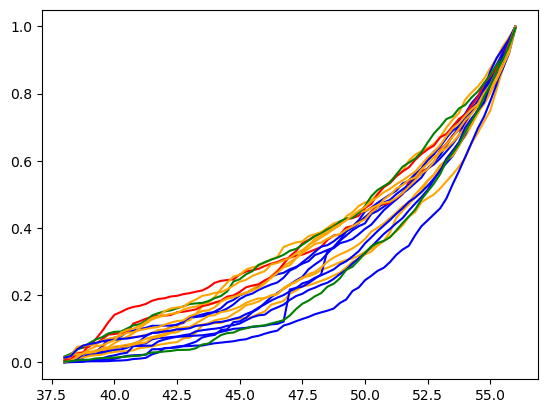

In [35]:
Colors = {'A':'teal','B':'teal','C':'#881a58','D':'#881a58'}
# Colors = {'A':'lightblue','B':'mediumseagreen','C':'tan','D':'plum'}
Colors = {'A':'b','B':'g','C':'orange','D':'r'}
for i, neu in neu_types.iterrows():
    name = neu.neu_name
    c = Colors[neu.neu_type]
    try:
        plt.plot(results_df2.timepoints[:], results_df1[name][:], c=c)
    except:
        pass

In [43]:
results_df['211114_P36_N3'].sum()

0.9974763364706197

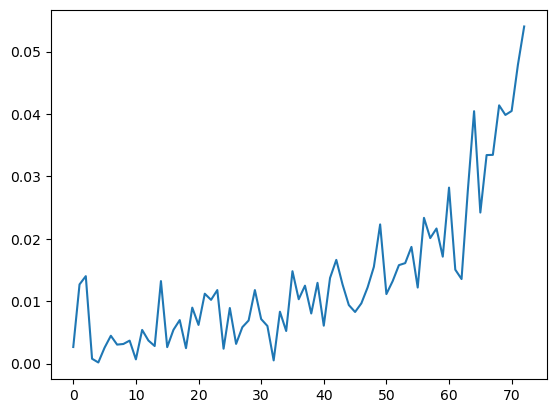

: 

In [48]:
plt.plot(results_df['211113_P36_N1'])

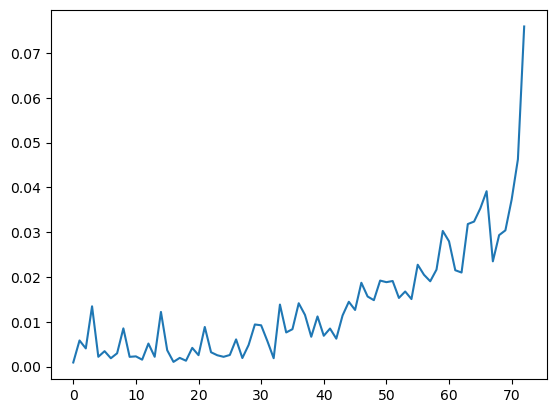

In [47]:
plt.plot(results_df['211113_P36_N2'])

In [20]:
neu_types

,neu_type,neu_name
0,A,220209_P36_N2
1,C,220209_P36_N1
2,D,220127_P36_N1
3,C,211121_P36.5_N3
4,A,211121_P36.5_N2
5,A,211121_P36.5_N1
6,C,211114_P36_N3
7,A,211114_P36_N2
8,A,211114_P36_N1
9,A,211113_P36_N2


In [104]:
# getting filenames of TLI CSV files and the subtype of each neuron
Colors = {'A':'b','B':'g','C':'orange','D':'r'}
tli_data = '/home/tli_project/Desktop/Data/T4/neurons/output/New/'
output_files = datautils.get_file_names(tli_data, group_by='_', order=True, nested_files=False, criteria='.csv')
neu_types = {}
for neu in output_files:
    name = os.path.splitext(os.path.basename(neu))[0]
    neu_types[name] = name.split('_s')[1]
neu_types = {'neu_type':list(neu_types.values()),'neu_name':list(neu_types.keys())}
neu_types = pd.DataFrame(neu_types)
neu_types.neu_name = [n[:-3] for n in neu_types.neu_name]

first 5 files
['/home/tli_project/Desktop/Data/T4/neurons/output/New/220209_P36_N2_sA.csv', '/home/tli_project/Desktop/Data/T4/neurons/output/New/220209_P36_N1_sC.csv', '/home/tli_project/Desktop/Data/T4/neurons/output/New/220127_P36_N1_sD.csv', '/home/tli_project/Desktop/Data/T4/neurons/output/New/211121_P36.5_N3_sC.csv', '/home/tli_project/Desktop/Data/T4/neurons/output/New/211121_P36.5_N2_sA.csv']


In [132]:
for neu in results_df.columns[1:]:
    name = os.path.basename(neu)[:-17]
    results_df.rename(columns = {neu:name}, inplace = True)

In [134]:
results_df1.columns[1:]

Index(['220209_P36_N1', '220127_P36_N1', '211121_P36.5_N3', '211121_P36.5_N2',
       '211121_P36.5_N1', '211114_P36_N3', '211114_P36_N2', '211114_P36_N1',
       '211113_P36_N2', '211113_P36_N1', '211107_P36_N3', '211107_P36_N2',
       '211107_P36_N1', '211104_P36_N3', '211104_P36_N2', '211104_P36_N1',
       '211011_P37_N1'],
      dtype='object')

In [135]:
for i, neu in neu_types.iterrows():
    name = neu.neu_name
    plt.plot(results_df2.timepoints[:], results_df1[name][:])

KeyError: '220209_P36_N2'

In [129]:
results_df1['220209_P36_N2']

KeyError: '220209_P36_N2'

In [108]:
for neu in results_df1.columns[1:]:
    name = os.path.basename(neu)[:-17]
    c= Colors[neu_types[neu_types.neu_name==name].neu_type]
    plt.plot(results_df2.timepoints[:], results_df1[neu][:], c=c)
plt.legend(bbox_to_anchor=(1.2, 0.97))


TypeError: unhashable type: 'Series'

In [121]:
subtype = neu_types[neu_types.neu_name==name]['neu_type']
Colors[subtype]

TypeError: unhashable type: 'Series'

In [125]:
for i, neu in neu_types.iterrows():
    print(i,neu)

0 neu_type                A
neu_name    220209_P36_N2
Name: 0, dtype: object
1 neu_type                C
neu_name    220209_P36_N1
Name: 1, dtype: object
2 neu_type                D
neu_name    220127_P36_N1
Name: 2, dtype: object
3 neu_type                  C
neu_name    211121_P36.5_N3
Name: 3, dtype: object
4 neu_type                  A
neu_name    211121_P36.5_N2
Name: 4, dtype: object
5 neu_type                  A
neu_name    211121_P36.5_N1
Name: 5, dtype: object
6 neu_type                C
neu_name    211114_P36_N3
Name: 6, dtype: object
7 neu_type                A
neu_name    211114_P36_N2
Name: 7, dtype: object
8 neu_type                A
neu_name    211114_P36_N1
Name: 8, dtype: object
9 neu_type                A
neu_name    211113_P36_N2
Name: 9, dtype: object
10 neu_type                C
neu_name    211113_P36_N1
Name: 10, dtype: object
11 neu_type                D
neu_name    211107_P36_N3
Name: 11, dtype: object
12 neu_type                C
neu_name    211107_P36_N2
Name:

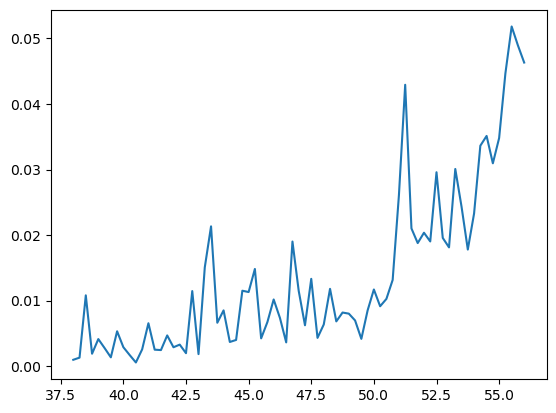

In [34]:
plt.plot(results_df.timepoints, results_df['/home/tli_project/Desktop/Data/T4/neurons/output/cols_labeled/all/211114_P36_N3_cols_labeled.tif'], label=name)

In [42]:
name[:14]

'211011_P37_N1_'

In [35]:
results_df1 = results_df.cumsum()

In [38]:
results_df1.iloc[-1]

timepoints                                                                                            3431.0
/home/tli_project/Desktop/Data/T4/neurons/output/cols_labeled/all/220209_P36_N1_cols_labeled.tif         1.0
/home/tli_project/Desktop/Data/T4/neurons/output/cols_labeled/all/220127_P36_N1_cols_labeled.tif         1.0
/home/tli_project/Desktop/Data/T4/neurons/output/cols_labeled/all/211121_P36.5_N3_cols_labeled.tif       1.0
/home/tli_project/Desktop/Data/T4/neurons/output/cols_labeled/all/211121_P36.5_N2_cols_labeled.tif       1.0
/home/tli_project/Desktop/Data/T4/neurons/output/cols_labeled/all/211121_P36.5_N1_cols_labeled.tif       1.0
/home/tli_project/Desktop/Data/T4/neurons/output/cols_labeled/all/211114_P36_N3_cols_labeled.tif         1.0
/home/tli_project/Desktop/Data/T4/neurons/output/cols_labeled/all/211114_P36_N2_cols_labeled.tif         1.0
/home/tli_project/Desktop/Data/T4/neurons/output/cols_labeled/all/211114_P36_N1_cols_labeled.tif         1.0
/home/tli_project/D

In [ ]:
aa

In [11]:
start = 38
end = 56
timepoints = {'timepoints' : np.arange(start,end+0.25,0.25)}
# results_cols = []
results_df = pd.DataFrame(timepoints)
for neu, n_folder in enumerate(N_folders):
    start_im = re.search('P(.*)_N', n_folder)
    start_im = float(start_im.group(1))
    start_ana = int((start_age - start_im)/0.25)
    files_list = datautils.get_file_names(data_path+n_folder, group_by='', 
                                        order=True, nested_files=False, 
                                        criteria='')
    neu_path = [f for f in files_list if 'clahe' in f.lower()][0]
    neuron = tif.imread(neu_path)
    mask_path = [f for f in files_list if 'mask' in f.lower()][0]
    mask = tif.imread(mask_path)
    neuron[mask==0] = 0
    neuron = neuron[start_ana:] #remove timepoints before start_ana from the 4D image array
    neuron[neuron != 0] = 1
    lifetimes = analysis.cal_lifetimes(neuron, save=False)
    lifetimes = lifetimes[-1].astype(float)
    lifetimes[lifetimes>0] = 37+0.25*(lifetimes.max()-lifetimes[lifetimes>0])

    sample = lifetimes[(lifetimes>=start) & (lifetimes<=end)]
    total = len(sample)
    result = []
    for i in results_df.timepoints:
        subset = sample[sample==i]
        result.append(len(subset)/total)
    results_df[n_folder] = np.array(result)



first 5 files
['/home/tli_project/Desktop/Data/T4/neurons/SubtypeB/211011_P37_N1/test_line.tif', '/home/tli_project/Desktop/Data/T4/neurons/SubtypeB/211011_P37_N1/original_cols_3.png', '/home/tli_project/Desktop/Data/T4/neurons/SubtypeB/211011_P37_N1/original_cols_2.png', '/home/tli_project/Desktop/Data/T4/neurons/SubtypeB/211011_P37_N1/original_cols_10.png', '/home/tli_project/Desktop/Data/T4/neurons/SubtypeB/211011_P37_N1/mywarpedgrid_3.png']


100%|██████████| 84/84 [00:02<00:00, 38.38it/s]


38.0
38.25
38.5
38.75
39.0
39.25
39.5
39.75
40.0
40.25
40.5
40.75
41.0
41.25
41.5
41.75
42.0
42.25
42.5
42.75
43.0
43.25
43.5
43.75
44.0
44.25
44.5
44.75
45.0
45.25
45.5
45.75
46.0
46.25
46.5
46.75
47.0
47.25
47.5
47.75
48.0
48.25
48.5
48.75
49.0
49.25
49.5
49.75
50.0
50.25
50.5
50.75
51.0
51.25
51.5
51.75
52.0
52.25
52.5
52.75
53.0
53.25
53.5
53.75
54.0
54.25
54.5
54.75
55.0
55.25
55.5
55.75
56.0
first 5 files
['/home/tli_project/Desktop/Data/T4/neurons/SubtypeB/211107_P36_N1/211107_P36_N1_Z30.70_clahe.tif', '/home/tli_project/Desktop/Data/T4/neurons/SubtypeB/211107_P36_N1/211107_P36_N1_Z30.70_5D.tif', '/home/tli_project/Desktop/Data/T4/neurons/SubtypeB/211107_P36_N1/211107_P36_N1_R265_mask1.tif', '/home/tli_project/Desktop/Data/T4/neurons/SubtypeB/211107_P36_N1/211107_P36_N1_R265_Z30.70_5D.tif', '/home/tli_project/Desktop/Data/T4/neurons/SubtypeB/211107_P36_N1/211107_P36_N1_R265_ColRois.zip']


100%|██████████| 87/87 [00:01<00:00, 48.42it/s]

38.0
38.25
38.5
38.75
39.0
39.25
39.5
39.75
40.0
40.25
40.5
40.75
41.0
41.25
41.5
41.75
42.0
42.25
42.5
42.75
43.0
43.25
43.5
43.75
44.0
44.25
44.5
44.75
45.0
45.25
45.5
45.75
46.0
46.25
46.5
46.75
47.0
47.25
47.5
47.75
48.0
48.25
48.5
48.75
49.0
49.25
49.5
49.75
50.0
50.25
50.5
50.75
51.0
51.25
51.5
51.75
52.0
52.25
52.5
52.75
53.0
53.25
53.5
53.75
54.0
54.25
54.5
54.75
55.0
55.25
55.5
55.75
56.0


In [10]:
result

[0.0]

In [12]:
results_df.head()

,timepoints,211011_P37_N1,211107_P36_N1
0,38.00,0.002528,0.010662
1,38.25,0.001575,0.018936
2,38.50,0.002337,0.005246
3,38.75,0.001013,0.009198
4,39.00,0.001113,0.020006


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


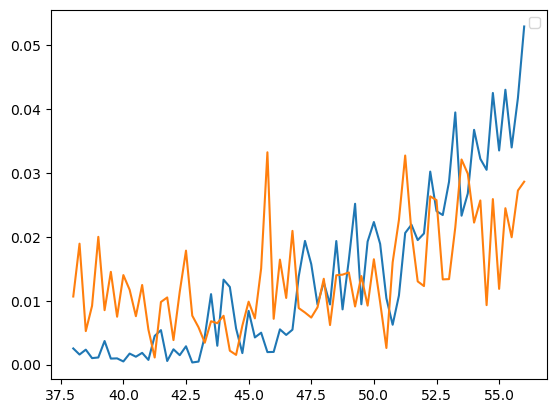

In [21]:
plt.plot(np.arange(start,end+0.25,0.25), results_df['211011_P37_N1'])
plt.plot(np.arange(start,end+0.25,0.25), results_df['211107_P36_N1'])
plt.legend()

In [74]:
result.sum()

1.0

In [30]:
subset = sample[(sample>=56) & (sample<57)]
len(subset)/total

0.1828500751503006

In [35]:
subset = sample[(sample>=57)]
len(subset)/total

0.07798409318637274

(array([ 1885.,  1035.,     0.,   622.,     0.,  1078.,     0.,  2055.,
            0.,  2184.,     0.,  1944.,     0.,  2047.,  3013.,     0.,
         2396.,     0.,  2335.,     0.,  2854.,     0.,  3937.,     0.,
         2325.,     0.,  2673.,     0.,  3665.,  3212.,     0.,  3041.,
            0.,  4241.,     0.,  3343.,     0.,  4291.,     0.,  3390.,
            0.,  4162.,     0.,  5279.,  4817.,     0.,  6713.,     0.,
         6549.,     0.,  9962.,     0., 12611.,     0., 16454.,     0.,
        27052., 45351.]),
 array([50.25      , 50.38362069, 50.51724138, 50.65086207, 50.78448276,
        50.91810345, 51.05172414, 51.18534483, 51.31896552, 51.45258621,
        51.5862069 , 51.71982759, 51.85344828, 51.98706897, 52.12068966,
        52.25431034, 52.38793103, 52.52155172, 52.65517241, 52.7887931 ,
        52.92241379, 53.05603448, 53.18965517, 53.32327586, 53.45689655,
        53.59051724, 53.72413793, 53.85775862, 53.99137931, 54.125     ,
        54.25862069, 54.39224138

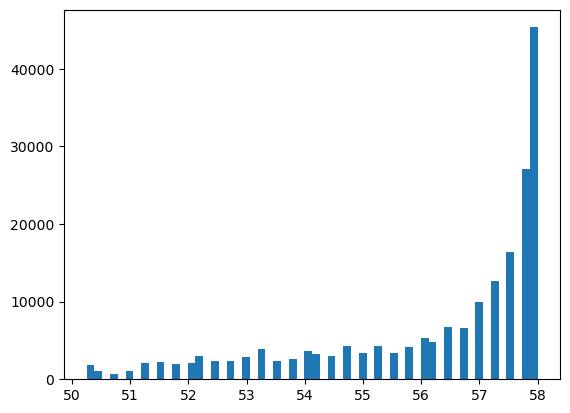

In [34]:
plt.hist(lifetimes[(lifetimes>50) & (lifetimes<59)], bins=58)

In [ ]:
result_cols = ['neuron','X','Y','angle']
results = pd.DataFrame(columns=result_cols)
for n_folder in N_folders:
    start_im = re.search('P(.*)_N', n_folder)
    start_im = float(start_im.group(1))
    start_ana = int((start_age - start_im)/0.25)
    files_list = datautils.get_file_names(data_path+n_folder, group_by='', 
                                        order=True, nested_files=False, 
                                        criteria='')
    neu_path = [f for f in files_list if 'clahe' in f.lower()][0]
    neuron = tif.imread(neu_path)
    mask_path = [f for f in files_list if 'mask' in f.lower()][0]
    mask = tif.imread(mask_path)
    neuron[mask==0] = 0
    neuron = neuron[start_ana:] #remove timepoints before start_ana from the 4D image array
    neuron[neuron != 0] = 1
    x,y,res_angle = cal_lifetimes_angle(neuron, plot=True)
    results[n_folder]=[n_folder,x,y,res_angle]

In [280]:
37+0.25*(86-2)

58.0

100%|██████████| 85/85 [00:05<00:00, 16.83it/s]


(3.508425077487061, -38.55903487633398, -84.80106401697839)

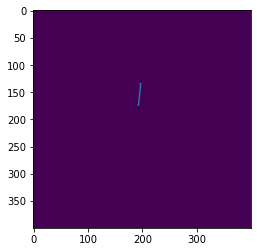

In [306]:
cal_lifetimes_angle(mask)

In [413]:
# neuron = 
mask = tif.imread('/Users/aichah/Desktop/TLI/data/subtypeC/211104_P36_N3_R290_JE_mask.tif')

100%|██████████| 88/88 [00:07<00:00, 12.02it/s]


(22.21680948533674, -10.569736677595643, -25.442957427798344)

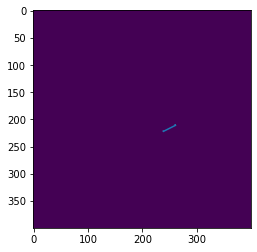

In [388]:
cal_lifetimes_angle(mask)

In [389]:
lifetimes = analysis.cal_lifetimes(mask, save=False)

100%|██████████| 88/88 [00:06<00:00, 13.19it/s]


In [341]:
test = lifetimes[-1]

In [343]:
test[test>0] = 37+0.25*(test.max()-test[test>0])

In [344]:
test.max(), test.min()

(58.25, 0.0)

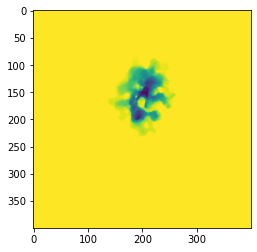

In [293]:
plt.imshow(np.mean(test, axis=0))

In [303]:
test2 = test.copy().astype('uint8')
test2[test2!=0]=1
test_region = regionprops(label_image=test2, intensity_image=test)[0]

In [304]:
test_region.centroid, test_region.centroid_weighted

((21.5, 199.5, 199.5),
 (21.498936103055666, 199.62503245757134, 199.49137335356164))

In [295]:
test.dtype

dtype('float64')

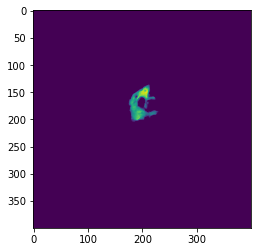

In [291]:
t1 = test.copy()
t1[t1>40] = 0
# t1[t1<40] = 2
plt.imshow(t1.mean(axis=0))

100%|██████████| 85/85 [00:04<00:00, 17.37it/s]


0.9694183513092298 -4.033453581067022 -76.48560523563609


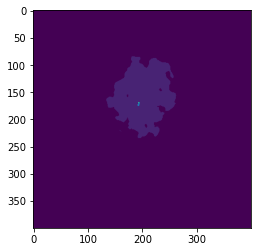

In [354]:
lifetimes = analysis.cal_lifetimes(mask, save=False)
lifetimes = lifetimes[-1]
lifetimes[lifetimes>0] = 37+0.25*(lifetimes.max()-lifetimes[lifetimes>0])
# lifetimes = test.copy()
# lifetimes = lifetimes[-1].astype(np.float32)
# lifetimes = 37+0.25*(lifetimes.max()-lifetimes)

t1 = lifetimes.copy()
t1[t1>43.5] = 0
t1 = t1.astype('uint8')
t1_center = regionprops(t1)[0].centroid
t2 = lifetimes.copy()
t2[t2<55.25] = 0
t2 = t2.astype('uint8')
t2_center = regionprops(t2)[0].centroid

x,y = (t2_center[-1]-t1_center[-1]) , (t2_center[-2]-t1_center[-2])
t_angle = np.degrees(np.arctan2(y,x))
print(x, y, t_angle)

y1,x1 = int(t1_center[-2]),int(t1_center[-1])
y2,x2 = int(t2_center[-2]),int(t2_center[-1])
t_plot = test.sum(axis=0)
t_plot[t_plot!=0] = 1
t_plot[y1-1:y1+1,x1-1:x1+1]=5
t_plot[y2-1:y2+1,x2-1:x2+1]=10
plt.imshow(t_plot)
plt.plot((x1,x2),(y1,y2))

100%|██████████| 85/85 [00:04<00:00, 17.23it/s]


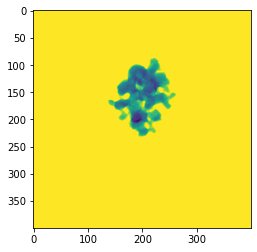

In [361]:
lifetimes = analysis.cal_lifetimes(mask, save=False)
lifetimes = lifetimes[-1]
t_plot=lifetimes.copy()
t_plot[t_plot!=0] = 1
t_plot[lifetimes>60] = 5
t_plot[lifetimes<10] = 20
plt.imshow(t_plot.mean(axis=0))

In [393]:
t1_center = regionprops(mask[0])[0].centroid
t2_center = regionprops(mask[-1]-mask[0])[0].centroid
x,y = (t2_center[-1]-t1_center[-1]) , (t2_center[-2]-t1_center[-2])
t_angle = np.degrees(np.arctan2(y,x))
print(x, y, t_angle)

41.488656012674966 34.29376948478614 39.57651730280875


100%|██████████| 88/88 [00:04<00:00, 20.64it/s]


-16.244928483236663 30.838908268501584 117.77879489919786


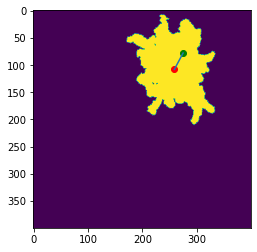

In [425]:
lifetimes = analysis.cal_lifetimes(mask, save=False)
lifetimes = lifetimes[-1].astype(float)
# lifetimes[lifetimes>0] = 37+0.25*(lifetimes.max()-lifetimes[lifetimes>0])

t1 = lifetimes.copy()
t1[t1<60] = 0
t1 = t1.astype('uint8')
t1_center = regionprops(t1)[0].centroid
t2 = lifetimes.copy()
t2[t2>13] = 0
t2 = t2.astype('uint8')
t2_center = regionprops(t2)[0].centroid

x,y = (t2_center[-1]-t1_center[-1]) , (t2_center[-2]-t1_center[-2])

t_angle = np.degrees(np.arctan2(y,x))
print(x, y, t_angle)

y1,x1 = int(t1_center[-2]),int(t1_center[-1])
y2,x2 = int(t2_center[-2]),int(t2_center[-1])
t_plot = lifetimes.sum(axis=0)
t_plot[t_plot!=0] = 1
# t_plot[y1-1:y1+1,x1-1:x1+1]=5
# t_plot[y2-1:y2+1,x2-1:x2+1]=10
plt.imshow(t_plot)
plt.plot((x1,x2),(y1,y2))
plt.scatter(x1,y1,c='g')
plt.scatter(x2,y2,c='r')

11.389853615811234 -30.224053485409087 -69.35121666109683


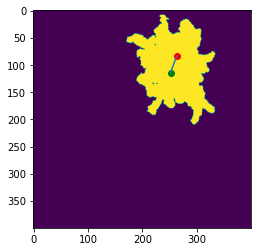

In [423]:
t1_center = regionprops(mask[20])[0].centroid
t2_center = regionprops(mask[-20]-mask[20])[0].centroid
x,y = (t2_center[-1]-t1_center[-1]) , (t2_center[-2]-t1_center[-2])
t_angle = np.degrees(np.arctan2(y,x))
print(x, y, t_angle)
y1,x1 = int(t1_center[-2]),int(t1_center[-1])
y2,x2 = int(t2_center[-2]),int(t2_center[-1])
t_plot = lifetimes.sum(axis=0)
t_plot[t_plot!=0] = 1
# t_plot[y1-1:y1+1,x1-1:x1+1]=5
# t_plot[y2-1:y2+1,x2-1:x2+1]=10
plt.imshow(t_plot)
plt.plot((x1,x2),(y1,y2))
plt.scatter(x1,y1,c='g')
plt.scatter(x2,y2,c='r')

21.97988285985113 -35.2685639646582 -58.068238226998545


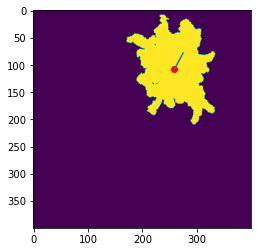

In [439]:
t1_center = regionprops(mask[0])[0].centroid
t2_center = regionprops(mask[-1]-mask[0])[0].centroid
x,y = (t2_center[-1]-t1_center[-1]) , (t2_center[-2]-t1_center[-2])
t_angle = np.degrees(np.arctan2(y,x))
print(x, y, t_angle)
# y1,x1 = int(t1_center[-2]),int(t1_center[-1])
# y2,x2 = int(t2_center[-2]),int(t2_center[-1])
t_plot = lifetimes.sum(axis=0)
t_plot[t_plot!=0] = 1
# t_plot[y1-1:y1+1,x1-1:x1+1]=5
# t_plot[y2-1:y2+1,x2-1:x2+1]=10
plt.imshow(t_plot)
plt.plot((x1,x2),(y1,y2))
plt.scatter(x2,y2,c='r')

14.773567990635229 -26.842745483699844 -61.172726159414935


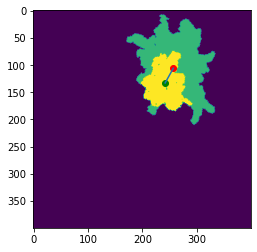

In [503]:
# mask1 = mask.sum(axis=0)
t1 = mask[0].sum(axis=0)
t1[t1!=0] = 1
t2 = (mask[-1] - mask[0]).sum(axis=0)
t2[t2!=0] = 2

t1_center = regionprops(t1)[0].centroid
t2_center = regionprops(t2)[0].centroid
x,y = (t2_center[-1]-t1_center[-1]) , (t2_center[-2]-t1_center[-2])
t_angle = np.degrees(np.arctan2(y,x))
print(x, y, t_angle)

t1 = t1 + t2
plt.imshow(t1)
y1,x1 = int(t1_center[-2]),int(t1_center[-1])
y2,x2 = int(t2_center[-2]),int(t2_center[-1])
plt.plot((x1,x2),(y1,y2))
plt.scatter(x1,y1,c='g')
plt.scatter(x2,y2,c='r')

In [463]:
lifetimes.max()

89.0

In [462]:
lifetimes = analysis.cal_lifetimes(mask, save=False)
# lifetimes = lifetimes[-1].astype(float)
# lifetimes[lifetimes>0] = 37+0.25*(lifetimes.max()-lifetimes[lifetimes>0])

100%|██████████| 88/88 [00:04<00:00, 20.49it/s]


9.883587001234076 3.995680789798442 22.01222081045574


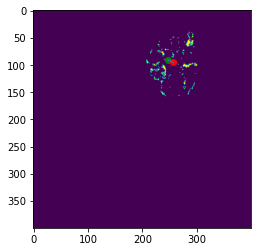

In [467]:
# mask1 = mask.sum(axis=0)
lifetimes1 = np.median(lifetimes, axis=0)
t1 = lifetimes1.copy().astype('uint8')
t1[t1!=76] = 0
# t1 = t1.max(axis=0).astype('uint8')
t1[t1!=0] = 1
t2 = lifetimes1.copy().astype('uint8')
t2[t2!=4] = 0
# t2 = t2.max(axis=0).astype('uint8')
t2[t2!=0] = 2

t1_center = regionprops(t1)[0].centroid
t2_center = regionprops(t2)[0].centroid
x,y = (t2_center[-1]-t1_center[-1]) , (t2_center[-2]-t1_center[-2])
t_angle = np.degrees(np.arctan2(y,x))
print(x, y, t_angle)

t1 = t1 + t2
plt.imshow(t1)
y1,x1 = int(t1_center[-2]),int(t1_center[-1])
y2,x2 = int(t2_center[-2]),int(t2_center[-1])
plt.plot((x1,x2),(y1,y2))
plt.scatter(x1,y1,c='g')
plt.scatter(x2,y2,c='r')

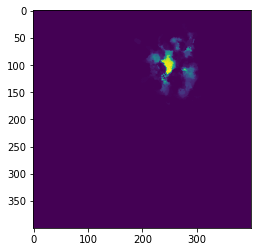

In [468]:
plt.imshow(lifetimes1)

In [471]:
mask1 = mask.max(axis=1)
lifetimes2 = analysis.cal_lifetimes(mask1, save=False)

100%|██████████| 88/88 [00:00<00:00, 1049.79it/s]


In [475]:
lifetimes2.max()

89.0

4.353836209039798 28.61260006961365 81.34795748886475


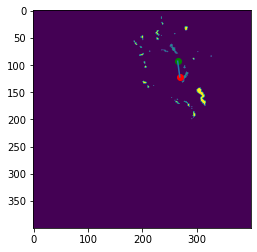

In [477]:
t1 = lifetimes2[-1].copy().astype('uint8')
t1[t1!=76] = 0
t1[t1!=0] = 1
t2 = lifetimes2[-1].copy().astype('uint8')
t2[t2!=4] = 0
# t2 = t2.max(axis=0).astype('uint8')
t2[t2!=0] = 2

t1_center = regionprops(t1)[0].centroid
t2_center = regionprops(t2)[0].centroid
x,y = (t2_center[-1]-t1_center[-1]) , (t2_center[-2]-t1_center[-2])
t_angle = np.degrees(np.arctan2(y,x))
print(x, y, t_angle)

t1 = t1 + t2
plt.imshow(t1)
y1,x1 = int(t1_center[-2]),int(t1_center[-1])
y2,x2 = int(t2_center[-2]),int(t2_center[-1])
plt.plot((x1,x2),(y1,y2))
plt.scatter(x1,y1,c='g')
plt.scatter(x2,y2,c='r')

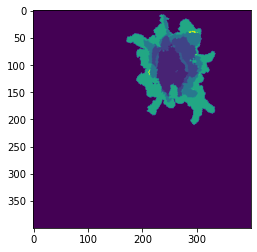

In [499]:
test = lifetimes2[-1].copy()
test[test<75] = 0
test[test!=0] = 1
t = lifetimes2[-1].copy()
t[(t>75) | (t<50)] = 0
t[t!=0] = 2
test = test + t

t = lifetimes2[-1].copy()
t[(t>50) | (t<30)] = 0
t[t!=0] = 4
test = test + t

t = lifetimes2[-1].copy()
t[(t>30) | (t<1)] = 0
t[t!=0] = 6
test = test + t

plt.imshow(test)

In [500]:
test.dtype

dtype('float64')

In [501]:
test = test*100
test_region = regionprops(label_image=lifetimes2[-1].astype('uint8'), intensity_image=test)[0]

In [502]:
test_region.centroid, test_region.centroid_weighted

((128.49596231493945, 257.94751009421265),
 (128.49596231493945, 257.94751009421265))

2.6364885329836056 7.8619122256531 71.46114677602277


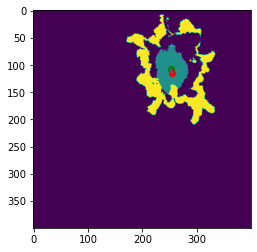

In [489]:
t1 = lifetimes2[-1].copy().astype('uint8')
t1[t1<75] = 0
t1[t1!=0] = 1
t2 = lifetimes2[-1].copy().astype('uint8')
t2[(t2>30)] = 0
# t2 = t2.max(axis=0).astype('uint8')
t2[t2!=0] = 2

t1_center = regionprops(t1)[0].centroid
t2_center = regionprops(t2)[0].centroid
x,y = (t2_center[-1]-t1_center[-1]) , (t2_center[-2]-t1_center[-2])
t_angle = np.degrees(np.arctan2(y,x))
print(x, y, t_angle)

t1 = t1 + t2
plt.imshow(t1)
y1,x1 = int(t1_center[-2]),int(t1_center[-1])
y2,x2 = int(t2_center[-2]),int(t2_center[-1])
plt.plot((x1,x2),(y1,y2))
plt.scatter(x1,y1,c='g')
plt.scatter(x2,y2,c='r')

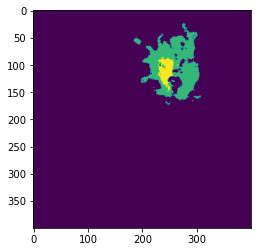

In [436]:
t1 = test.copy()
t1[t1>39] = 0
t1[t1!=0] = 1
t2 = test.copy()
# t2[t2<50] = 0
t2[t2!=0] = 2
t1 = t1 + t2
plt.imshow(t1)

In [ ]:
lifetimes = analysis.cal_lifetimes(mask, save=False)
lifetimes = lifetimes[-1].astype(float)
# lifetimes[lifetimes>0] = 37+0.25*(lifetimes.max()-lifetimes[lifetimes>0])

t1 = lifetimes.copy()
t1[t1<60] = 0
t1 = t1.astype('uint8')
t1_center = regionprops(t1)[0].centroid
t2 = lifetimes.copy()
t2[t2>13] = 0
t2 = t2.astype('uint8')
t2_center = regionprops(t2)[0].centroid

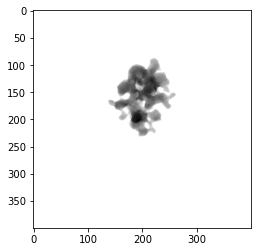

In [380]:
lifetimes[lifetimes<10] = 1000
plt.imshow(lifetimes.mean(axis=0), cmap='gist_gray')

In [368]:
lifetimes = analysis.cal_lifetimes(mask[::-1], save=False)
lifetimes = lifetimes[1].astype(float)
# lifetimes = 37+0.25*(lifetimes.max()-lifetimes)

t1 = lifetimes.copy()
t1[t1<60] = 0
t1 = t1.astype('uint8')
t1_center = regionprops(t1)[0].centroid
t2 = lifetimes.copy()
t2[t2>13] = 0
t2 = t2.astype('uint8')
t2_center = regionprops(t2)[0].centroid

x,y = (t2_center[-1]-t1_center[-1]) , (t2_center[-2]-t1_center[-2])

t_angle = np.degrees(np.arctan2(y,x))
print(x, y, t_angle)

y1,x1 = int(t1_center[-2]),int(t1_center[-1])
y2,x2 = int(t2_center[-2]),int(t2_center[-1])
t_plot = lifetimes.sum(axis=0)
t_plot[t_plot!=0] = 1
t_plot[y1-1:y1+1,x1-1:x1+1]=5
t_plot[y2-1:y2+1,x2-1:x2+1]=10
plt.imshow(t_plot)
plt.plot((x1,x2),(y1,y2))

100%|██████████| 85/85 [00:05<00:00, 16.83it/s]


IndexError: list index out of range

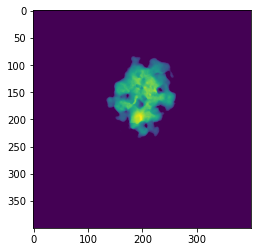

In [366]:
plt.imshow(mask[-1].sum(axis=0))

(0.0, 90.0)

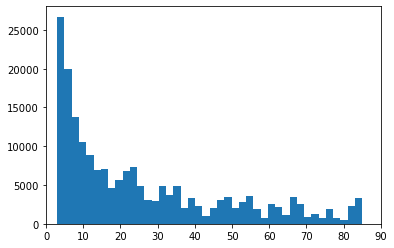

In [265]:
test = lifetimes[-1].astype('uint8')
test[test>85] = 0
t = test[test>2]
plt.hist(t,bins=int(t.max()/2))
plt.xlim(0,90)

(4.0, 90.0)

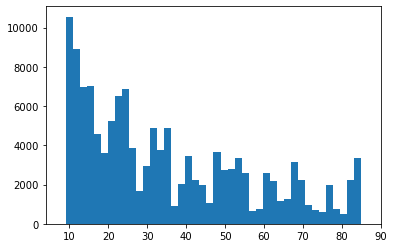

In [266]:
test = lifetimes[-1].astype('uint8')
test[test>85] = 0
t = test[test>8]
plt.hist(t,bins=int(t.max()/2))
plt.xlim(4,90)

(4.0, 90.0)

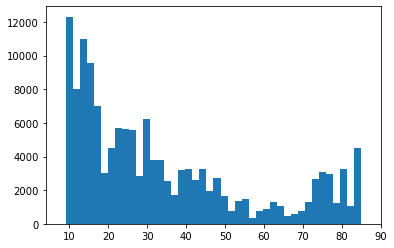

In [255]:
# test = lifetimes[-1].astype('uint8')
# t = test[test>0]
# plt.hist(t,bins=int(t.max()/2))

test = lifetimes[-1].astype('uint8')
test[test>85] = 0
t = test[test>8]
plt.hist(t,bins=int(t.max()/2))
plt.xlim(4,90)

(4.0, 90.0)

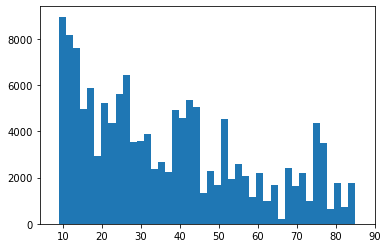

In [251]:
test = lifetimes[-1].astype('uint8')
test[test>85] = 0
t = test[test>8]
plt.hist(t,bins=int(t.max()/2))
plt.xlim(4,90)

In [219]:
lifetimes.shape

(89, 37, 400, 400)

In [87]:
test = lifetimes[-1]
test = test.astype('float')
test = test/4
test -= test.max()
test = test * -1
# test += test.min()
# test[test < 5] = np.nan

In [88]:
test.max(), test.min()

(22.25, -0.0)

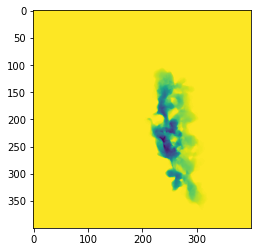

In [103]:
test2 = np.mean(test, axis=0)
test2[test2<10]=0
plt.imshow(test2)

In [121]:
test = lifetimes[-1].astype('uint8')
test_region = regionprops(test)[0]

In [130]:
test_region.centroid

(36.56324522638206, 230.88815698046082, 267.2552322187943)

In [123]:
test_region.centroid_weighted

AttributeError: '<class 'skimage.measure._regionprops.RegionProperties'>' object has no attribute 'centroid_weighted'

In [124]:
from skimage.measure import moments_central, moments
M = moments(test)
centroid = (M[1, 0] / M[0, 0], M[0, 1] / M[0, 0])
# moments_central(image, centroid)

In [125]:
centroid

(array([34.74915063, 34.79952865, 34.85318139, 34.91002107]),
 array([227.59680551, 229.33249498, 231.1400795 , 233.01540956]))

In [127]:
test.max()

89

In [185]:
import cv2
test=lifetimes[-1]
test = test.astype(float)
t = np.mean(test, axis=0)
t[t>0] = np.reciprocal(t[t>0])
# t = np.reciprocal(t)
# t[t>0] -= t.max()
# t = t * -1
mo = cv2.moments(t,binaryImage=False)
xs = mo['m10']/mo['m00']
ys = mo['m01']/mo['m00']
# ys = mo['m01']/mo['m00']
ys, xs

(234.7540002025629, 270.74278274247416)

In [168]:
test_region.centroid

(36.56324522638206, 230.88815698046082, 267.2552322187943)

In [173]:
import cv2
test = mask[-1]
test = test.astype(float)

# t = test.sum(axis=0)
mo = cv2.moments(t,binaryImage=False)
xs = mo['m10']/mo['m00']
ys = mo['m01']/mo['m00']
# ys = mo['m01']/mo['m00']
ys, xs

(nan, nan)

In [187]:
x,y = (267.25-234.75) , (230.89-270.75)
np.degrees(np.arctan2(y,x))

-50.80778956198833

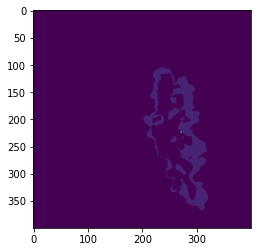

In [194]:
t[t!=0] = 1
# t[234:236,269:271]=10
t[223:225,271:273]=10
plt.imshow(t)

In [191]:
import cv2
test=lifetimes[-1]
test = test.astype(float)
t = np.mean(test, axis=0)
t[t>5] = 0
# plt.imshow(t)
mo = cv2.moments(t,binaryImage=False)
xs = mo['m10']/mo['m00']
ys = mo['m01']/mo['m00']
# ys = mo['m01']/mo['m00']
ys, xs

(224.56065958693225, 272.3185131844901)

In [179]:
np.reciprocal(t[t>0]).max()

56.0

In [180]:
t[t>0] = np.reciprocal(t[t>0])

In [220]:
test = lifetimes[-1].astype(float)
# test = test/4
t1 = test.copy()
t1[t1<60] = 0
t1 = t1.astype('uint8')
t1_center = regionprops(t1)[0].centroid
t2 = test.copy()
t2[t2>20] = 0
t2 = t2.astype('uint8')
t2_center = regionprops(t2)[0].centroid
t1_center, t2_center

((18.499021526418787, 78.06457925636008, 275.4021526418787),
 (18.473759870817826, 108.90348752486166, 259.157224158642))

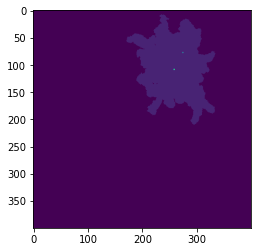

In [221]:
t_plot = test.sum(axis=0)
t_plot[t_plot!=0] = 1
t_plot[77:79,274:276]=5
t_plot[108:110,258:260]=10
plt.imshow(t_plot)

In [222]:
x,y = (t2_center[-1]-t1_center[-1]) , (t2_center[-2]-t1_center[-2])
np.degrees(np.arctan2(y,x))

117.77879489919786

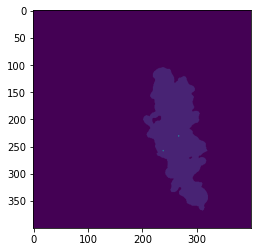

In [216]:
t_plot = test.sum(axis=0)
t_plot[t_plot!=0] = 1
t_plot[257:259,238:240]=5
t_plot[230:232,267:268]=10
plt.imshow(t_plot)

In [206]:
x,y = (t2_center[-1]-t1_center[-1]) , (t2_center[-2]-t1_center[-2])
np.degrees(np.arctan2(y,x))

-44.15026086389054

In [23]:
test[test==1].sum(),test[test==2].sum()/2, test[test==4].sum()/4, test[test==10].sum()/10

(35979.0, 19854.0, 10192.0, 3880.0)

In [215]:
test = lifetimes[-1]
test = test.astype('uint16')
test_region = regionprops(test,intensity_image=test)[0]
test_region.centroid_weighted, test_region.centroid

((36.56324522638205, 230.88815698046082, 267.2552322187943),
 (36.56324522638206, 230.88815698046082, 267.2552322187943))

In [8]:
test = np.array([1,0,0,1,1])
binary_fill_holes(test).astype(int)

array([1, 1, 1, 1, 1, 1])

For explanation of the the individual columns in the result csv file, expand the next cell

In [2]:
"""" Results' columns' description 
'neuron':  neuron name extracted from file name
'subtype': neuron name extracted from file name
'entry_point': entry point of the neuron, read from seperate txt file

'volume': number of pixels in the 3D masked image
'net_area': number of pixels in the 2D masked image (the 2D is a sum projection of the 3D image)
'area': area of the convex_hull surronding the 2D image (obtained from skimage.measure.regionprops)
'AP_spread': (max-min) of value pixels index in last (x) dimension of the 2D image
'DV_spread': (max-min) of value pixels index in (y) dimension of the 2D image

'density_2D': solidity value obtained from skimage.measure.regionprops on the 2D image
'density_3D': pixel count of 3D image/pixel count of 3D convexhull 
'object_perimeter': object perimenter value obtained from skimage.measure.regionprops on the 2D image
'convex_perimeter': perimeter of the surronding convex_hull

'circularity': (4*np.pi*convex_area)/(convex_perimeter**2)
'compactness': object_perimeter**2/(4*np.pi*net_area)
'surface_area': mesh_surface_area of the marching_cubes on the 3D masked image
'eccentricity': eccentricity value obtained from skimage.measure.regionprops on the 2D image 
>>>> change to 3D >>>>  'convexity': convex_perimeter/object_perimeter (maybe try surface_area/3D_image_convex_surface area)
'orientation': orientation value obtained from skimage.measure.regionprops on the 2D image 
'feret_diameter_max': feret_diameter_max value obtained from skimage.measure.regionprops on the 2D image 
'DGI':

'centroidZ': Z position of the centroid from regionprops on the 3D masked image 
'centroidY': Y position of the centroid from regionprops on the 3D masked image 
'centroidX': X position of the centroid from regionprops on the 3D masked image 
'cen_EP_dis': ecludian distance of the centroid from the entry point
'cen_EP_angle': angle of the line between centroid from the entry point (np.arctan2)

£££ PCA analysis
'asymmetry':
'xP_weight', 'xP_scale','xP_angle','xP_xy':
'xN_weight','xN_scale','xN_angle','xN_xy',
'yP_weight','yP_scale','yP_angle','yP_xy',
'yN_weight','yN_scale','yN_angle','yN_xy',
'PCA_angle':
'PCA_xy':
'PCA_shift_centroid':
"""

'" Results\' columns\' description \n\'neuron\':  neuron name extracted from file name\n\'subtype\': neuron name extracted from file name\n\'entry_point\': entry point of the neuron, read from seperate txt file\n\n\'volume\': number of pixels in the 3D masked image\n\'net_area\': number of pixels in the 2D masked image (the 2D is a sum projection of the 3D image)\n\'area\': area of the convex_hull surronding the 2D image (obtained from skimage.measure.regionprops)\n\'AP_spread\': (max-min) of value pixels index in last (x) dimension of the 2D image\n\'DV_spread\': (max-min) of value pixels index in (y) dimension of the 2D image\n\n\'density_2D\': solidity value obtained from skimage.measure.regionprops on the 2D image\n\'density_3D\': pixel count of 3D image/pixel count of 3D convexhull \n\'object_perimeter\': object perimenter value obtained from skimage.measure.regionprops on the 2D image\n\'convex_perimeter\': perimeter of the surronding convex_hull\n\n\'circularity\': (4*np.pi*conv

In [3]:
from tqdm import tqdm
import os
import re
import tifffile as tif

import utils.analysis as analysis
import utils.datautils as datautils

import numpy as np
from skimage.measure import regionprops, marching_cubes, mesh_surface_area, perimeter
import pandas as pd
import math
from scipy.spatial import ConvexHull

import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib.patches as mpatches
# import seaborn as sns
%matplotlib inline

from timeit import default_timer as timer
from multiprocessing import cpu_count, Process, Pool

In [4]:
#  input and save paths
data_path = '/home/tli_project/Desktop/Data/T4/neurons/SubtypeB/'
save_path = '/home/tli_project/Desktop/Data/T4/neurons/SubtypeB/output/'
subtype = 'B'
# stab_limit = 5 #(No. of timepoints for stable branches calculation)
start_age = 37

In [5]:
# getting list of folders in data_path, where each folder has files for one neuron
N_folders = [name for name in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, name))]
N_folders = [f for f in N_folders if '_P' in f]
N_folders = sorted(N_folders)
N_folders

['211011_P37_N1', '211107_P36_N1']

In [6]:
# reading erntry_points file and converting it to dictionary of neu:[z,y,x]
EP_file = '/home/tli_project/Desktop/Data/T4/neurons/TLI_stage1_entry_points'
with open(EP_file) as f:
    entry_points = f.readlines()
entry_points = [l for l in entry_points if ': ' in l]
entry_points = [l.rstrip('\n').split(':') for l in entry_points]
entry_points = {l[0]: l[1].split(',') for l in entry_points}
entry_points = {neu:[int(x) for x in val] for neu,val in entry_points.items()}

In [7]:
results_cols = ['timepoint', 'volume', '3D_convex_volume', 'net_area', 'area',
                'AP_spread', 'DV_spread',
                'density_2D', 'density_3D', 'object_perimeter', 'convex_perimeter', 
                'circularity', 'compactness', 'surface_area', '3D_convex_surface',
                'eccentricity', 'convexity_2D', 'convexity_3D', 'orientation',
                'feret_diameter_max',
                'DGI',
                'centroidZ','centroidY', 'centroidX', 
                'cen_EP_dis', 'cen_EP_angle', 'cen_EP_Y','cen_EP_X',
                'asymmetry', 'x_asymmetry', 'y_asymmetry', 'PC1_asymmetry', 'PC2_asymmetry',
                'xP_weight','xP_scale','xP_angle','xP_xy', #all of this part is for the results from PCA_analysis
                'xN_weight','xN_scale','xN_angle','xN_xy',
                'yP_weight','yP_scale','yP_angle','yP_xy',
                'yN_weight','yN_scale','yN_angle','yN_xy',
                'PC1_angle','PC1_x','PC1_y']
# results_df = pd.DataFrame(columns=results_cols)
# for i in range(100):
#     results_df.loc[start_age+i*0.25] = [None for col in results_df.columns]

In [8]:
def process_image(n_file):
    neuron_results = pd.DataFrame(columns=results_cols)
    entry_point = entry_points[n_file][1:] # remove the first T element
    start_im = re.search('P(.*)_N', n_file)
    start_im = float(start_im.group(1))
    start_ana = int((start_age - start_im)/0.25)
    files_list = datautils.get_file_names(data_path+n_file, group_by='', 
                                        order=True, nested_files=False, 
                                        criteria='')
    neu_path = [f for f in files_list if 'clahe' in f.lower()][0]
    neuron = tif.imread(neu_path)
    mask_path = [f for f in files_list if 'mask' in f.lower()][0]
    mask = tif.imread(mask_path)
    neuron[mask==0] = 0
    neuron = neuron[start_ana:] #remove timepoints before start_ana from the 4D image array
    neuron[neuron != 0] = 1
    neu_2D = neuron.max(axis=1)
    neuron_results['timepoint'] = [start_age+i*0.25 for i in range(len(neu_2D))]
    neuron_results['volume'] = neuron.sum(axis=tuple(np.arange(len(neuron.shape))[1:]))
    neuron_results['net_area'] = neu_2D.sum(axis=tuple(np.arange(len(neu_2D.shape))[1:]))
    for t, stack in enumerate(neuron):
        reg_prop_2D = regionprops(neu_2D[t])[0]
        reg_prop_3D = regionprops(stack)[0]
        neuron_results.loc[t,'density_2D'] = reg_prop_2D.solidity
        neuron_results.loc[t,'area'] = reg_prop_2D.area_convex
        neuron_results.loc[t,'orientation'] = reg_prop_2D.orientation
        neuron_results.loc[t,'eccentricity'] = reg_prop_2D.eccentricity
        neuron_results.loc[t,'feret_diameter_max'] = reg_prop_2D.feret_diameter_max
        neuron_results.loc[t,'convex_perimeter'] = perimeter(reg_prop_2D.image_convex)
        neuron_results.loc[t,'object_perimeter'] = reg_prop_2D.perimeter
        neuron_results.loc[t,['centroidZ','centroidY','centroidX']] = reg_prop_3D.centroid
        neuron_results.loc[t,'3D_convex_volume'] = reg_prop_3D.area_convex
        neuron_results.loc[t,'density_3D'] = neuron_results.loc[t,'volume']/neuron_results.loc[t,'3D_convex_volume']
        img_PC = reg_prop_3D.coords
        neuron_results.loc[t,'DV_spread'] = (img_PC[:,1].max() - img_PC[:,1].min())*0.076
        neuron_results.loc[t,'AP_spread'] = (img_PC[:,2].max() - img_PC[:,2].min())*0.076
        centroid_EP = np.array(entry_point)-np.array(reg_prop_3D.centroid)
        neuron_results.loc[t,'cen_EP_dis'] = np.linalg.norm(centroid_EP[1:])
        neuron_results.loc[t,['cen_EP_Y','cen_EP_X']] = centroid_EP[1:]
        p1 = (centroid_EP[1],centroid_EP[2])
        neuron_results.loc[t,'cen_EP_angle'] = np.rad2deg((np.arctan2(*p1[::-1])) % (2 * np.pi))

        verts, faces, normals, values = marching_cubes(stack, step_size=2, spacing=(0.4,0.076,0.076))
        neuron_results.loc[t,'surface_area'] = mesh_surface_area(verts, faces)
        convex_img_3D = reg_prop_3D.image_convex.astype('uint8')
        verts, faces, normals, values = marching_cubes(convex_img_3D, step_size=2, spacing=(0.4,0.076,0.076))
        neuron_results.loc[t,'3D_convex_surface'] = mesh_surface_area(verts, faces)
        neuron_results.loc[t,'convexity_3D'] = neuron_results.loc[t,'3D_convex_surface']/neuron_results.loc[t,'surface_area']

        asymmetry_values, PCA_df, shifted_coor = analysis.metric_dump(neu_2D[t],entry_point[1:],plot=False)
        asymmetries = ['asymmetry', 'x_asymmetry', 'y_asymmetry', 'PC1_asymmetry', 'PC2_asymmetry']
        neuron_results.loc[t,asymmetries]  = asymmetry_values

        PCA_res = ['xP_weight','xP_scale','xP_angle','xP_xy',
                    'xN_weight','xN_scale','xN_angle','xN_xy',
                    'yP_weight','yP_scale','yP_angle','yP_xy',
                    'yN_weight','yN_scale','yN_angle','yN_xy']
        PCA_arr = np.array(PCA_df.loc[:, PCA_df.columns != 'axis'])
        neuron_results.loc[t,PCA_res]  = PCA_arr.ravel()
        neuron_results.loc[t,'PC1_angle'] = PCA_df.loc[PCA_df.Fraction_weight.idxmax()].Angle
        neuron_results.loc[t,'PC1_x'] = PCA_df.loc[PCA_df.Fraction_weight.idxmax()].xy[0]
        neuron_results.loc[t,'PC1_y'] = PCA_df.loc[PCA_df.Fraction_weight.idxmax()].xy[1]
        # neuron_results.loc[t,'PC1_shift_centroid'] = (sum(shifted_coor[:,1]) / len(shifted_coor), sum(shifted_coor[:,0]) / len(shifted_coor))
        
        neuron_results.loc[t,'DGI'] = analysis.DGI_3D(stack,entry_point)

    neuron_results['convexity_2D'] = neuron_results['convex_perimeter']/neuron_results['object_perimeter']
    neuron_results['circularity'] = (4*np.pi*neuron_results['area'])/(neuron_results['convex_perimeter']**2)
    neuron_results['compactness'] = neuron_results['object_perimeter']#     p = Pool(cpu_count()-1)
    csv_name = save_path+n_file+'_s'+subtype+'.csv'
    neuron_results.to_csv(csv_name)
    return neuron_results

# if __name__ == '__main__':
#     # c = cpu_count()-1
#     with Pool(3) as p:
#         p.map(process_image, N_folders)

for n_file in tqdm(N_folders):
    process_image(n_file)

  0%|          | 0/2 [00:00<?, ?it/s]

first 5 files
['/home/tli_project/Desktop/Data/T4/neurons/SubtypeB/211011_P37_N1/test_line.tif', '/home/tli_project/Desktop/Data/T4/neurons/SubtypeB/211011_P37_N1/original_cols_3.png', '/home/tli_project/Desktop/Data/T4/neurons/SubtypeB/211011_P37_N1/original_cols_2.png', '/home/tli_project/Desktop/Data/T4/neurons/SubtypeB/211011_P37_N1/original_cols_10.png', '/home/tli_project/Desktop/Data/T4/neurons/SubtypeB/211011_P37_N1/mywarpedgrid_3.png']


In [ ]:
# for i, n_file in tqdm(enumerate(N_folders)):
#     neuron_results = pd.DataFrame(columns=results_cols)
#     entry_point = entry_points[n_file][1:]
#     start_im = re.search('P(.*)_N', n_file)
#     start_im = float(start_im.group(1))
#     start_ana = int((start_age - start_im)/0.25)
#     files_list = datautils.get_file_names(data_path+n_file, group_by='', 
#                                         order=True, nested_files=False, 
#                                         criteria='')
#     neu_path = [f for f in files_list if 'clahe' in f.lower()][0]
#     neuron = tif.imread(neu_path)
#     mask_path = [f for f in files_list if 'mask' in f.lower()][0]
#     mask = tif.imread(mask_path)
#     neuron[mask==0] = 0
#     neuron = neuron[start_ana:] #remove timepoints before start_ana from the 4D image array
#     neuron[neuron != 0] = 1
#     neu_2D = neuron.max(axis=1)
#     neu_2D = neuron.max(axis=1)
#     neuron_results['timepoint'] = [start_age+i*0.25 for i in range(len(neu_2D))]
#     neuron_results['volume'] = neuron.sum(axis=tuple(np.arange(len(neuron.shape))[1:]))
#     neuron_results['net_area'] = neu_2D.sum(axis=tuple(np.arange(len(neu_2D.shape))[1:]))

#     reg_prop_2D = []
#     reg_prop_3D = []
#     for t, stack in enumerate(neuron):
#         reg_prop_2D.append(regionprops(neu_2D[t])[0])
#         reg_prop_3D.append(regionprops(stack)[0])
#         img_PC = reg_prop_3D[t].coords
#         neuron_results.loc[t,'DV_spread'] = (img_PC[:,1].max() - img_PC[:,1].min())*0.076
#         neuron_results.loc[t,'AP_spread'] = (img_PC[:,2].max() - img_PC[:,2].min())*0.076
#         neuron_results.loc[t,'density_3D'] = neuron_results.loc[t,'volume']/regionprops(stack)[0].area_convex

#         verts, faces, normals, values = marching_cubes(stack, step_size=2, spacing=(0.4,0.076,0.076))
#         neuron_results.loc[t,'surface_area'] = mesh_surface_area(verts, faces)
#         convex_img_3D = reg_prop_3D[t].image_convex.astype('uint8')
#         verts, faces, normals, values = marching_cubes(convex_img_3D, step_size=2, spacing=(0.4,0.076,0.076))
#         neuron_results.loc[t,'convexity_3D'] = mesh_surface_area(verts, faces)/neuron_results.loc[t,'surface_area']

#         asymmetry_values, PCA_df, shifted_coor = analysis.metric_dump(neu_2D[t],entry_point[1:],plot=False)
#         asymmetries = ['asymmetry', 'x_asymmetry', 'y_asymmetry', 'PC1_asymmetry', 'PC2_asymmetry']
#         neuron_results.loc[t,asymmetries]  = asymmetry_values

#         PCA_res = ['xP_weight','xP_scale','xP_angle','xP_xy',
#                     'xN_weight','xN_scale','xN_angle','xN_xy',
#                     'yP_weight','yP_scale','yP_angle','yP_xy',
#                     'yN_weight','yN_scale','yN_angle','yN_xy']
#         PCA_arr = np.array(PCA_df.loc[:, PCA_df.columns != 'axis'])
#         neuron_results.loc[t,PCA_res]  = PCA_arr.ravel()
#         neuron_results.loc[t,'PC1_angle'] = PCA_df.loc[PCA_df.Fraction_weight.idxmax()].Angle
#         neuron_results.loc[t,'PC1_x'] = PCA_df.loc[PCA_df.Fraction_weight.idxmax()].xy[0]
#         neuron_results.loc[t,'PC1_y'] = PCA_df.loc[PCA_df.Fraction_weight.idxmax()].xy[1]

#         neuron_results.loc[t,['centroidZ','centroidY','centroidX']] = reg_prop_3D[t].centroid
#         centroid_EP = np.array(entry_point)-np.array(reg_prop_3D[t].centroid)
#         neuron_results.loc[t,'cen_EP_dis'] = np.linalg.norm(centroid_EP[1:])
#         neuron_results.loc[t,['cen_EP_Y','cen_EP_X']] = centroid_EP[1:]
#         p1 = (centroid_EP[1],centroid_EP[2])
#         neuron_results.loc[t,'cen_EP_angle'] = np.rad2deg((np.arctan2(*p1[::-1])) % (2 * np.pi))


#     del neuron, neu_2D
#     neuron_results['density_2D'] = [r.solidity for r in reg_prop_2D]
#     # neuron_results['density_3D'] = [r.area_convex for r in reg_prop_3D]
#     # neuron_results['density_3D'] = neuron_results.loc[t,'volume']/neuron_results['density_3D']
#     neuron_results['area'] = [r.area_convex for r in reg_prop_2D]
#     neuron_results['orientation'] = [r.orientation for r in reg_prop_2D]
#     neuron_results['eccentricity'] = [r.eccentricity for r in reg_prop_2D]
#     neuron_results['feret_diameter_max'] = [r.feret_diameter_max for r in reg_prop_2D]
#     neuron_results['convex_perimeter'] = [perimeter(r.image_convex) for r in reg_prop_2D]
#     neuron_results['object_perimeter'] = [r.perimeter for r in reg_prop_2D]
#     neuron_results['convexity_2D'] = neuron_results['convex_perimeter']/neuron_results['object_perimeter']
#     neuron_results['circularity'] = (4*np.pi*neuron_results['area'])/(neuron_results['convex_perimeter']**2)
#     neuron_results['compactness'] = neuron_results['object_perimeter']**2/(4*np.pi*neuron_results['net_area'])
#     del reg_prop_2D, reg_prop_3D

#     csv_name = save_path+n_file+'_s'+subtype+'_new_111.csv'
#     neuron_results.to_csv(csv_name)